# Experiments with synthetic data
**Aim: train model that works on realistic synthetic data**

Parameters to vary: 
- radius (0.5)
- proportion_hemispheres_lesional (0.3)
- proportion_features_abnormal (0.2)

Experiments:
- 3 layer network no smoothing of lesions (synth_3layer)
    - Baseline_nosmooth (radius 2, prop_lesional 0.9, prop_features 0.9)
    - Features_abnormal0.2_nosmooth (radius 2, prop_lesional 0.9, prop_features 0.2)
    - Radius0.5_nosmooth (radius 0.5, prop_lesional 0.9, prop_features 0.2)
- 3 layer network WITH smoothing (synth_3layer)
    - Baseline (radius 2, prop_lesional 0.9, prop_features 0.9)
    - prop_features0.2 (radius 2, prop_lesional 0.9, prop_features 0.2)
    - Radius0.5 (radius 0.5, prop_lesional 0.9, prop_features 0.2)
    - prop_lesional (radius 0.5, prop_lesional 0.3, prop_features 0.2)
- 3 layer network WITH smoothing + finetuning (synth_3layer)
    - BaselineFTprop_features0.2 (train prop_features0.2 from baseline)
    - BaselineFTprop_features0.2FTradius0.5 (train radius0.5 from BaselineFTprop_features0.2)
    - BaselineFTprop_features0.2FTradius0.5FTprop_lesion0.3 (train prop_lesion0.3 from BaselineFTprop_features0.2FTradius0.5)
   
    
- 3 layer network with real data (real_3layer)
    - from_scratch (no finetuning, with oversampling, all sites)
    - from_synth_baselineFTProp_features0.2 (with finetuning from baselineFTprop_features0.2)
    - from_synth_baselineFTProp_features0.2 (with finetuning from baselineFTprop_features0.2)
    
- Unet (synth_unet)
    - prop_features0.2 (radius 2, prop_lesional 0.9, prop_features 0.2)
    
Results:
- smoothing makes task a bit harder, but still tain-able
- 3 layer model trains well with prop_features 0.2, a bit worse with additional radius 0.5 and only a little bit with additional prop_lesional 0.3 (most realistic config)
- 3 layer model on real data does not learn. Finetuning from synthetic does not yet work
- 3 layer model on synthetic data: finetuning works well and improves final performance on harder data

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from meld_graph.paths import EXPERIMENT_PATH
import os
#import seaborn as sns
from meld_graph.experiment import Experiment, discover_trained_experiments

Setting EXPERIMENT_PATH to /rds/project/kw350/rds-kw350-meld/experiments_graph/co-spit1
Setting MELD_DATA_PATH to /home/co-spit1/meld_data
Setting BASE_PATH to /home/co-spit1/meld_data
Setting EXPERIMENT_PATH to /home/co-spit1/meld_experiments/co-spit1
Setting FS_SUBJECTS_PATH to /home/co-spit1/meld_data/output/fs_outputs


### define plotting fns

In [2]:
import collections

def flatten(d, parent_key='', sep='_'):
    items = []
    for k, v in d.items():
        new_key = parent_key + sep + k if parent_key else k
        if isinstance(v, collections.MutableMapping):
            items.extend(flatten(v, new_key, sep=sep).items())
        else:
            items.append((new_key, v))
    return dict(items)
            
def plot_scores(exps, score='loss', split='val', ax=None, title_prefix=''):
    # expects exps to be dict
    scores = []
    if ax is None:
        fig, ax = plt.subplots(1,1)
    for n, exp in sorted(exps.items(), key=lambda item: item[0]):
        scores = exp.get_scores(split=split)[score]
        ax.plot(scores.index, scores, label=n)
    ax.set_xlabel('epochs')
    ax.set_ylabel(score)
    ax.set_title(f'{title_prefix} {split} {score}')
    ax.legend()

### load data

In [4]:
model_base_paths = {
    # 3layer
    '3layer': '/rds/project/kw350/rds-kw350-meld/experiments_graph/co-spit1/22-08-22_synth_3layer',
    # 3layer real data
    '3layer_real': '/rds/project/kw350/rds-kw350-meld/experiments_graph/co-spit1/22-08-22_real_3layer',
    # unet
    'unet': '/rds/project/kw350/rds-kw350-meld/experiments_graph/co-spit1/22-08-22_synth_unet',
    # 3layer - more controls - smoothing / non-smoothing
    '3layer_smth': '/rds/project/kw350/rds-kw350-meld/experiments_graph/co-spit1/22-09-29_synth_3layer',
}

# get list of trained experiments
model_paths = {}
for name, path in model_base_paths.items():
    model_paths[name] = discover_trained_experiments(path)
print(model_paths)

# process paths to get nice descriptive model names and load experiments
models_dict = {}
for name, exp_list in model_paths.items():
    name_dict = {}
    for path in exp_list:
        exp_name = path.split('/')[-2]
        if 'nosmooth' in exp_name:
            #filter out nosmooth experiments
            continue
        name_dict[exp_name] = Experiment.from_folder(path)
    models_dict[name] = name_dict
print(models_dict)

Initialised Experiment 22-08-22_synth_3layer/prop_features0.2
Initialised Experiment 22-08-22_synth_3layer/baselineFTprop_features0.2FTradius0.5
Initialised Experiment 22-08-22_synth_3layer/baseline
Initialised Experiment 22-08-22_synth_3layer/prop_lesion0.3
Initialised Experiment 22-08-22_synth_3layer/baselineFTprop_features0.2FTradius0.5FTprop_lesion0.3
Initialised Experiment 22-08-22_synth_3layer/radius0.5


{'3layer': ['/rds/project/kw350/rds-kw350-meld/experiments_graph/co-spit1/22-08-22_synth_3layer/prop_features0.2/fold_00', '/rds/project/kw350/rds-kw350-meld/experiments_graph/co-spit1/22-08-22_synth_3layer/baselineFTprop_features0.2FTradius0.5/fold_00', '/rds/project/kw350/rds-kw350-meld/experiments_graph/co-spit1/22-08-22_synth_3layer/baseline/fold_00', '/rds/project/kw350/rds-kw350-meld/experiments_graph/co-spit1/22-08-22_synth_3layer/prop_lesion0.3/fold_00', '/rds/project/kw350/rds-kw350-meld/experiments_graph/co-spit1/22-08-22_synth_3layer/radius0.5_nosmooth/fold_00', '/rds/project/kw350/rds-kw350-meld/experiments_graph/co-spit1/22-08-22_synth_3layer/baseline_nosmooth/fold_00', '/rds/project/kw350/rds-kw350-meld/experiments_graph/co-spit1/22-08-22_synth_3layer/baselineFTprop_features0.2FTradius0.5FTprop_lesion0.3/fold_00', '/rds/project/kw350/rds-kw350-meld/experiments_graph/co-spit1/22-08-22_synth_3layer/radius0.5/fold_00', '/rds/project/kw350/rds-kw350-meld/experiments_graph/co-

Initialised Experiment 22-08-22_synth_3layer/baselineFTprop_features0.2
Initialised Experiment 22-08-22_real_3layer/from_scratch
Initialised Experiment 22-08-22_real_3layer/from_synth_baselineFTprop_features0.2FTradius0.5
Initialised Experiment 22-08-22_real_3layer/from_synth_baselineFTprop_features0.2
Initialised Experiment 22-08-22_synth_unet/prop_features0.2
Initialised Experiment 22-08-22_synth_unet/prop_features0.2_100epochs
Initialised Experiment 22-09-29_synth_3layer/baseline-smooth-prop_features0.2
Initialised Experiment 22-09-29_synth_3layer/baseline-prop_features0.2


{'3layer': {'prop_features0.2': <meld_graph.experiment.Experiment object at 0x2ad8c5552640>, 'baselineFTprop_features0.2FTradius0.5': <meld_graph.experiment.Experiment object at 0x2ad70721e250>, 'baseline': <meld_graph.experiment.Experiment object at 0x2ad70744c4c0>, 'prop_lesion0.3': <meld_graph.experiment.Experiment object at 0x2ad70721e100>, 'baselineFTprop_features0.2FTradius0.5FTprop_lesion0.3': <meld_graph.experiment.Experiment object at 0x2ad70744c040>, 'radius0.5': <meld_graph.experiment.Experiment object at 0x2ad70721e190>, 'baselineFTprop_features0.2': <meld_graph.experiment.Experiment object at 0x2ad70744c880>}, '3layer_real': {'from_scratch': <meld_graph.experiment.Experiment object at 0x2ad70721e0d0>, 'from_synth_baselineFTprop_features0.2FTradius0.5': <meld_graph.experiment.Experiment object at 0x2ad8c2ecefa0>, 'from_synth_baselineFTprop_features0.2': <meld_graph.experiment.Experiment object at 0x2ad8c562cdc0>}, 'unet': {'prop_features0.2': <meld_graph.experiment.Experime

In [52]:
# available scores
#models_dict['3layer']['baseline_nosmooth'].get_scores(split='val')

## Plot data

### 3 layer model

/rds/project/kw350/rds-kw350-meld/experiments_graph/co-spit1/22-08-22_synth_3layer/baseline/fold_00
/rds/project/kw350/rds-kw350-meld/experiments_graph/co-spit1/22-08-22_synth_3layer/baselineFTprop_features0.2/fold_00
/rds/project/kw350/rds-kw350-meld/experiments_graph/co-spit1/22-08-22_synth_3layer/baselineFTprop_features0.2FTradius0.5/fold_00
/rds/project/kw350/rds-kw350-meld/experiments_graph/co-spit1/22-08-22_synth_3layer/baselineFTprop_features0.2FTradius0.5FTprop_lesion0.3/fold_00
/rds/project/kw350/rds-kw350-meld/experiments_graph/co-spit1/22-08-22_synth_3layer/prop_features0.2/fold_00
/rds/project/kw350/rds-kw350-meld/experiments_graph/co-spit1/22-08-22_synth_3layer/prop_lesion0.3/fold_00
/rds/project/kw350/rds-kw350-meld/experiments_graph/co-spit1/22-08-22_synth_3layer/radius0.5/fold_00
/rds/project/kw350/rds-kw350-meld/experiments_graph/co-spit1/22-08-22_synth_3layer/baseline/fold_00
/rds/project/kw350/rds-kw350-meld/experiments_graph/co-spit1/22-08-22_synth_3layer/baselineFT

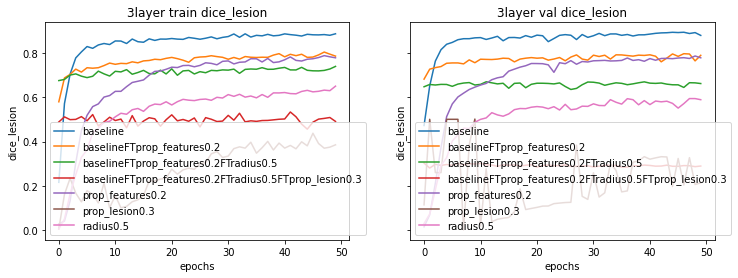

In [53]:
# linear model
fig, axes = plt.subplots(1,2, figsize=(12,4), sharey=True)
plot_scores(models_dict['3layer'], 'dice_lesion', split='train', ax=axes[0], title_prefix='3layer')
plot_scores(models_dict['3layer'], 'dice_lesion', split='val', ax=axes[1], title_prefix='3layer')


### unet model

/rds/project/kw350/rds-kw350-meld/experiments_graph/co-spit1/22-08-22_synth_unet/prop_features0.2/fold_00
/rds/project/kw350/rds-kw350-meld/experiments_graph/co-spit1/22-08-22_synth_unet/prop_features0.2_100epochs/fold_00
/rds/project/kw350/rds-kw350-meld/experiments_graph/co-spit1/22-08-22_synth_unet/prop_features0.2/fold_00
/rds/project/kw350/rds-kw350-meld/experiments_graph/co-spit1/22-08-22_synth_unet/prop_features0.2_100epochs/fold_00


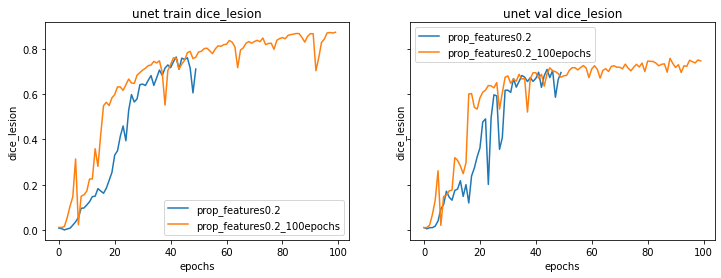

In [54]:
# linear model
fig, axes = plt.subplots(1,2, figsize=(12,4), sharey=True)
plot_scores(models_dict['unet'], 'dice_lesion', split='train', ax=axes[0], title_prefix='unet')
plot_scores(models_dict['unet'], 'dice_lesion', split='val', ax=axes[1], title_prefix='unet')

### 3 layer model trained on real data

/rds/project/kw350/rds-kw350-meld/experiments_graph/co-spit1/22-08-22_real_3layer/from_scratch/fold_00
/rds/project/kw350/rds-kw350-meld/experiments_graph/co-spit1/22-08-22_real_3layer/from_synth_baselineFTprop_features0.2/fold_00
/rds/project/kw350/rds-kw350-meld/experiments_graph/co-spit1/22-08-22_real_3layer/from_synth_baselineFTprop_features0.2FTradius0.5/fold_00
/rds/project/kw350/rds-kw350-meld/experiments_graph/co-spit1/22-08-22_real_3layer/from_scratch/fold_00
/rds/project/kw350/rds-kw350-meld/experiments_graph/co-spit1/22-08-22_real_3layer/from_synth_baselineFTprop_features0.2/fold_00
/rds/project/kw350/rds-kw350-meld/experiments_graph/co-spit1/22-08-22_real_3layer/from_synth_baselineFTprop_features0.2FTradius0.5/fold_00


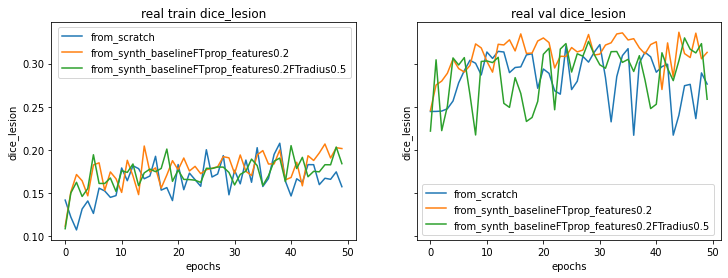

In [55]:
# linear model
fig, axes = plt.subplots(1,2, figsize=(12,4), sharey=True)
plot_scores(models_dict['3layer_real'], 'dice_lesion', split='train', ax=axes[0], title_prefix='real')
plot_scores(models_dict['3layer_real'], 'dice_lesion', split='val', ax=axes[1], title_prefix='real')

### 3 layer model with more controls

/rds/project/kw350/rds-kw350-meld/experiments_graph/co-spit1/22-09-29_synth_3layer/baseline-prop_features0.2/fold_00
/rds/project/kw350/rds-kw350-meld/experiments_graph/co-spit1/22-09-29_synth_3layer/baseline-smooth-prop_features0.2/fold_00
/rds/project/kw350/rds-kw350-meld/experiments_graph/co-spit1/22-09-29_synth_3layer/baseline-prop_features0.2/fold_00
/rds/project/kw350/rds-kw350-meld/experiments_graph/co-spit1/22-09-29_synth_3layer/baseline-smooth-prop_features0.2/fold_00


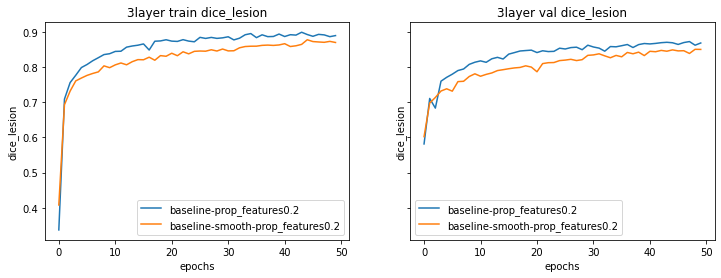

In [5]:
# linear model
fig, axes = plt.subplots(1,2, figsize=(12,4), sharey=True)
plot_scores(models_dict['3layer_smth'], 'dice_lesion', split='train', ax=axes[0], title_prefix='3layer')
plot_scores(models_dict['3layer_smth'], 'dice_lesion', split='val', ax=axes[1], title_prefix='3layer')